# Wprowadzenie

W tym notebooku przeprowadzimy analizę danych dotyczących różnych koktajli na podstawie dostarczonego pliku CSV o nazwie **all_cocktails.csv**. Celem analizy jest przygotowanie danych do zastosowania algorytmów klasteryzacji, które pozwolą nam pogrupować koktajle na podstawie wybranych cech.

## Zakres działań

1. **Załadowanie danych** – zaimportujemy plik CSV i wyodrębnimy istotne dla klasteryzacji cechy, takie jak:
   - `name` – nazwa koktajlu,
   - `alcoholic` – informacja o tym, czy koktajl zawiera alkohol,
   - `category_vector` – reprezentacja kategorii koktajlu w postaci wektora,
   - `glass_vector` – reprezentacja rodzaju szkła w postaci wektora,
   - `tag_vector_norm` – znormalizowane tagi opisujące koktajl,
   - `ingredient_vector_norm` – znormalizowane składniki użyte w koktajlu.

2. **Przygotowanie danych** – upewnimy się, że dane są odpowiednio przygotowane do dalszej analizy, a niepotrzebne kolumny zostaną pominięte.

3. **Wstępna analiza** – przed przystąpieniem do klasteryzacji, wykonamy wstępną eksplorację danych, aby lepiej zrozumieć ich strukturę i charakterystyki.

4. **Klasteryzacja** – zastosujemy odpowiednie algorytmy klasteryzacji, aby zgrupować podobne koktajle na podstawie wybranych cech.

## Cele

Głównym celem jest stworzenie modelu klasteryzacji, który pomoże pogrupować koktajle według podobieństw w ich składzie, kategorii, rodzajach szkła, czy też popularnych tagach.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import umap

# Wyłączenie ostrzeżeń za pomocą biblioteki warnings
import warnings
warnings.filterwarnings("ignore")

# Load the CSV file (adjust the file path as necessary)
file_path = "../outputs/all_cocktails.csv"
cocktails_df = pd.read_csv(file_path)

# Extract relevant columns: 'name', 'alcoholic', 'category_vector', 'glass_vector', 'tag_vector_norm', 'ingredient_vector_norm'
selected_columns = ['name', 'alcoholic', 'category_vector', 'glass_vector', 'tag_vector_norm', 'ingredient_vector_norm']
cocktails_selected = cocktails_df[selected_columns]

# Display the first few rows of the selected data
cocktails_selected.head()


,name,alcoholic,category_vector,glass_vector,tag_vector_norm,ingredient_vector_norm
0,Mojito,1,0,5,3.162278,2.236068
1,Old Fashioned,1,0,6,2.236068,2.000000
2,Long Island Tea,1,1,5,2.449490,2.449490
3,Negroni,1,1,6,1.414214,1.732051
4,Whiskey Sour,1,1,6,2.000000,2.000000


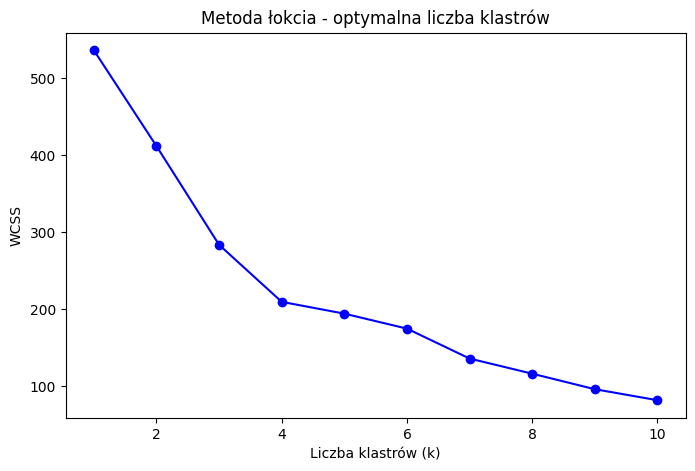

In [2]:
# Wybranie cech, które będą użyte do klasteryzacji
X = cocktails_df[['category_vector', 'glass_vector', 'tag_vector_norm', 'ingredient_vector_norm']]

# Standardyzacja danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Metoda łokcia do znalezienia optymalnej liczby klastrów
wcss = []  # Lista do przechowywania wartości WCSS dla różnych liczby klastrów
K = range(1, 11)  # Sprawdzamy dla liczby klastrów od 1 do 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)  # Używamy ustandaryzowanych danych
    wcss.append(kmeans.inertia_)  # inertia_ to suma WCSS dla bieżącego modelu

# Rysowanie wykresu WCSS
plt.figure(figsize=(8, 5))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('WCSS')
plt.title('Metoda łokcia - optymalna liczba klastrów')
plt.show()

In [3]:
# Obliczenie wskaźników dla 4 i 6 klastrów
results_comparison = {}

for n_clusters in [4, 6]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    silhouette_avg = silhouette_score(X_scaled, kmeans_labels)
    calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans_labels)
    davies_bouldin = davies_bouldin_score(X_scaled, kmeans_labels)
    sse = kmeans.inertia_
    
    # Dodanie wyników do słownika
    results_comparison[n_clusters] = {
        'Silhouette Score': silhouette_avg,
        'Calinski-Harabasz Index': calinski_harabasz,
        'Davies-Bouldin Index': davies_bouldin,
        'SSE': sse
    }


# Wyświetlenie wyników
results_comparison_df = pd.DataFrame(results_comparison).T
results_comparison_df

,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index,SSE
4,0.408123,67.579783,0.973047,209.413164
6,0.416827,52.957936,0.762901,174.668540


In [4]:
# Klasteryzacja za pomocą K-means dla 6 klastrów
kmeans = KMeans(n_clusters=6, random_state=42)
cocktails_df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Wyświetlenie pierwszych kilku wierszy z przypisanymi klastrami
cocktails_df[['name', 'kmeans_cluster']].head()


,name,kmeans_cluster
0,Mojito,2
1,Old Fashioned,2
2,Long Island Tea,3
3,Negroni,3
4,Whiskey Sour,3


In [5]:
# Klasteryzacja za pomocą K-means dla 6 klastrów
kmeans = KMeans(n_clusters=6, random_state=42)
cocktails_df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Grupowanie drinków według klastrów i wyświetlenie wyników
clustered_drinks_kmeans = cocktails_df.groupby('kmeans_cluster')['name'].apply(list)
cluster_sizes_kmeans = cocktails_df['kmeans_cluster'].value_counts().sort_index()

# Tworzenie DataFrame z wynikami dla każdego klastra
cluster_summary_kmeans = []
for cluster_num, drinks in clustered_drinks_kmeans.items():
    cluster_summary_kmeans.append({
        'Cluster': cluster_num,
        'Number of drinks': cluster_sizes_kmeans[cluster_num],
        'Drinks': drinks
    })

# Konwersja wyników do DataFrame
cluster_summary_kmeans_df = pd.DataFrame(cluster_summary_kmeans)

# Wyświetlenie wyników
cluster_summary_kmeans_df

,Cluster,Number of drinks,Drinks
0,0,46,"[Allegheny, Amaretto Tea, Apricot Lady, Archbi..."
1,1,53,"[After Supper Cocktail, Algonquin, Allies Cock..."
2,2,4,"[Mojito, Old Fashioned, Dry Martini, Manhattan]"
3,3,28,"[Long Island Tea, Negroni, Whiskey Sour, Daiqu..."
4,4,2,"[Martinez Cocktail, Martini]"
5,5,1,[Moscow Mule]


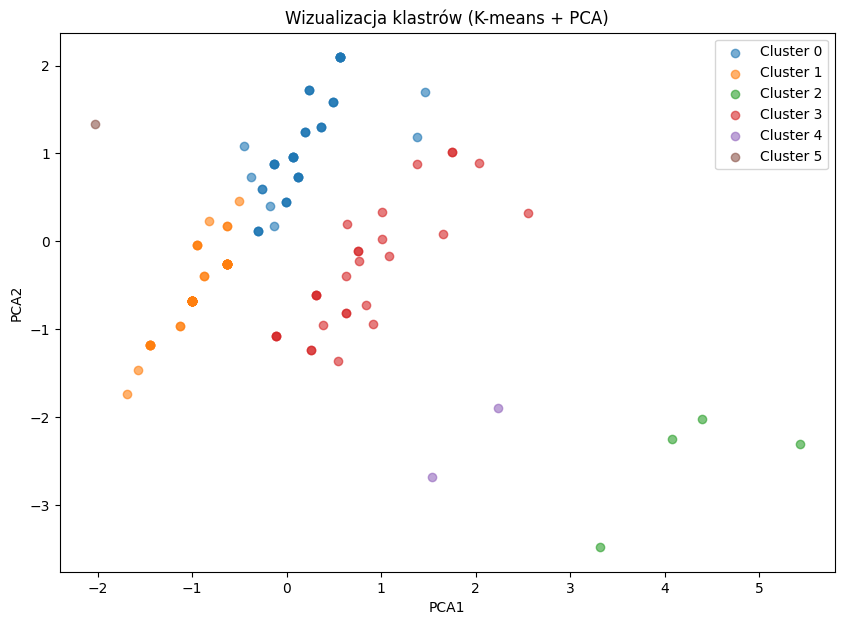

,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index,SSE
0,0.416827,52.957936,0.762901,174.66854


In [6]:
# Redukcja wymiarów za pomocą PCA (do 2 wymiarów)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Dodanie wymiarów PCA do DataFrame
cocktails_df['PCA1'] = X_pca[:, 0]
cocktails_df['PCA2'] = X_pca[:, 1]

# Wizualizacja klastrów K-means z redukcją wymiarów PCA
plt.figure(figsize=(10, 7))
for cluster in range(6):
    cluster_points = cocktails_df[cocktails_df['kmeans_cluster'] == cluster]
    plt.scatter(
        cluster_points['PCA1'],
        cluster_points['PCA2'],
        label=f'Cluster {cluster}',
        alpha=0.6
    )

plt.title('Wizualizacja klastrów (K-means + PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Obliczanie wskaźników jakości klasteryzacji dla K-means (6 klastrów)
silhouette_avg = silhouette_score(X_scaled, cocktails_df['kmeans_cluster'])
calinski_harabasz = calinski_harabasz_score(X_scaled, cocktails_df['kmeans_cluster'])
davies_bouldin = davies_bouldin_score(X_scaled, cocktails_df['kmeans_cluster'])
sse = kmeans.inertia_

# Wyświetlenie wyników
quality_metrics = {
    'Silhouette Score': silhouette_avg,
    'Calinski-Harabasz Index': calinski_harabasz,
    'Davies-Bouldin Index': davies_bouldin,
    'SSE': sse
}

# Konwersja wyników jakości klasteryzacji na DataFrame
quality_metrics_df = pd.DataFrame([quality_metrics])

# Wyświetlenie wyników w formie DataFrame
quality_metrics_df


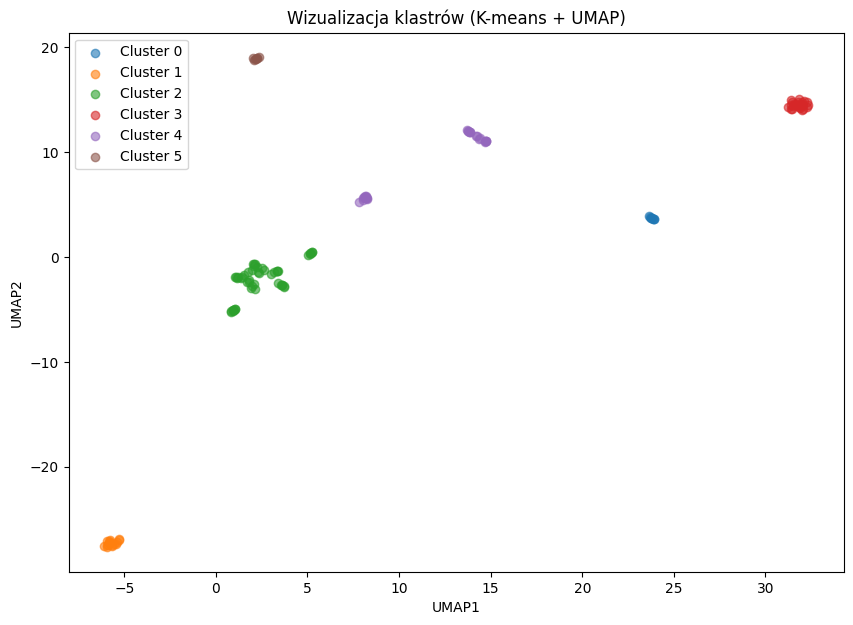

,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index,SSE
0,0.840784,1650.873047,0.297661,684.515686


In [7]:
# UMAP do redukcji wymiarów (do 2 wymiarów)
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embedding = reducer.fit_transform(X_scaled)

# Klasteryzacja za pomocą K-means (dla 6 klastrów)
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels_umap = kmeans.fit_predict(umap_embedding)

# Obliczanie wskaźników jakości klasteryzacji
silhouette_avg_umap = silhouette_score(umap_embedding, kmeans_labels_umap)
calinski_harabasz_umap = calinski_harabasz_score(umap_embedding, kmeans_labels_umap)
davies_bouldin_umap = davies_bouldin_score(umap_embedding, kmeans_labels_umap)
sse_umap = kmeans.inertia_

# Tworzenie DataFrame z wynikami jakości klasteryzacji
quality_metrics_umap = {
    'Silhouette Score': silhouette_avg_umap,
    'Calinski-Harabasz Index': calinski_harabasz_umap,
    'Davies-Bouldin Index': davies_bouldin_umap,
    'SSE': sse_umap
}

quality_metrics_umap_df = pd.DataFrame([quality_metrics_umap])

# Dodanie wyników UMAP i klastrów do DataFrame
cocktails_df['UMAP1'] = umap_embedding[:, 0]
cocktails_df['UMAP2'] = umap_embedding[:, 1]
cocktails_df['umap_kmeans_cluster'] = kmeans_labels_umap

# Wizualizacja klastrów K-means z redukcją wymiarów UMAP
plt.figure(figsize=(10, 7))
for cluster in range(6):
    cluster_points = cocktails_df[cocktails_df['umap_kmeans_cluster'] == cluster]
    plt.scatter(
        cluster_points['UMAP1'],
        cluster_points['UMAP2'],
        label=f'Cluster {cluster}',
        alpha=0.6
    )

plt.title('Wizualizacja klastrów (K-means + UMAP)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()

# Wyświetlenie wyników wskaźników jakości klasteryzacji
quality_metrics_umap_df

In [8]:
# Porównanie rozkładu cech w poszczególnych klastrach - analiza tagów i składników
# Sprawdzimy, jak tagi i składniki są rozłożone w poszczególnych klastrach

# Sprawdzanie tagów i składników w ramach klastrów K-means
cluster_analysis = cocktails_df.groupby('kmeans_cluster')[['tag_vector_norm', 'ingredient_vector_norm']].mean()

# Wyświetlenie wyników
cluster_analysis


,tag_vector_norm,ingredient_vector_norm
kmeans_cluster,,
0,0.043478,2.230652
1,0.000000,1.731808
2,2.282599,2.104402
3,1.417403,1.954722
4,0.000000,1.984059
5,1.414214,1.732051


# Analiza rozkładu cech w klastrach

Poniżej przedstawiono wnioski na podstawie analizy średnich wartości normalizowanych wektorów tagów i składników w poszczególnych klastrach stworzonych za pomocą algorytmu K-means:

- **tag_vector_norm**: Średnia wartość normalizowanego wektora tagów dla drinków w danym klastrze.
- **ingredient_vector_norm**: Średnia wartość normalizowanego wektora składników w każdym klastrze.

## Wnioski:

- Klastry **2**, **3**, i **5** mają wyższe wartości **tag_vector_norm**, co sugeruje, że w tych klastrach drinki mają więcej przypisanych tagów.
- Klaster **5** ma najwyższą wartość **ingredient_vector_norm**, co oznacza, że drinki w tym klastrze mają więcej składników w porównaniu do innych klastrów.
- Klastry **0** i **4** mają zerową wartość **tag_vector_norm**, co sugeruje brak tagów przypisanych do drinków w tych klastrach.
